In [228]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

sns.set_style('whitegrid')
sns.set_context('notebook')

# Chromosomes

## Bin Coverage of Genomes

Get crude bin identities via `chromosome_coverage/blast_chroms.sh`

BLASTN search of chromosomes as a databases for each set of binned query contigs.

Fortunately, there is only a single chromosome for each genome

In [181]:
chrom_df = pd.read_csv('chromosome_coverage/chroms_blast_all.out6', 
                 sep='\t', 
                 names = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovs bin".split())
chrom_df['species'] = chrom_df['sseqid'].str.split(':').str.get(0)

bin_sizes = pd.read_csv('bin_sizes.csv').set_index('bin')
genome_sizes = pd.read_csv('genome_sizes.csv').set_index('genome')

In [182]:
# assess how much of each reference genome is found inside each bin
# first we need to collapse the overlapping blast hits in the genome

genome_in_bin = {}
for ix, row in chrom_df.sort_values(['species', 'bin']).iterrows():
    if row['sstart'] < row['send']: 
        ix_covered = (row['sstart'], row['send'])
    else:
        ix_covered = (row['send'], row['sstart'])

    genome = row['species']
    bin = row['bin']
    
    if genome not in genome_in_bin:
        genome_in_bin.update({genome: {bin: [ix_covered]}})
    else:
        if bin in genome_in_bin[genome]:
            genome_in_bin[genome][bin].append(ix_covered)
        else:
            genome_in_bin[genome][bin] = [ix_covered]

def merge_intervals(intervals):

    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return merged


for genome in genome_in_bin:
    for bin in genome_in_bin[genome]:
        intervals = genome_in_bin[genome][bin] 
        merged_intervals = merge_intervals(intervals)
        
        # get combined length covered by intervals
        area = 0
        for interval in merged_intervals:
            area += interval[1] - interval[0]
        
        # normalise this by total length of genome chromosome
        proportion_of_genome = area / genome_sizes.loc[genome, 'nts'] * 100
        genome_in_bin[genome][bin] = proportion_of_genome
        

Text(0,0.5,'Genome')

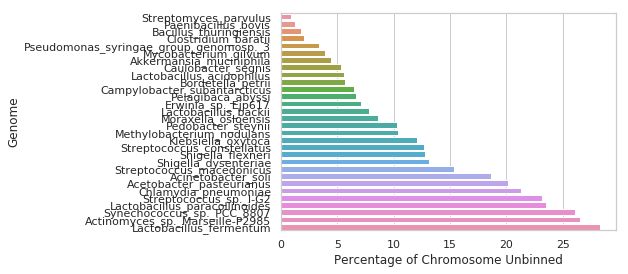

In [183]:
genome_cov = pd.melt(pd.DataFrame(genome_in_bin).reset_index().rename(columns={'index':'bin'}), 
                                                         id_vars='bin', value_name='genome_prop_in_bin', var_name='genome').fillna(0)

sns.barplot(data = genome_cov[genome_cov['bin'] == 'bin.unbinned.fa'].sort_values('genome_prop_in_bin'),
                       x = 'genome_prop_in_bin', y='genome')
plt.xlabel('Percentage of Chromosome Unbinned')
plt.ylabel('Genome')

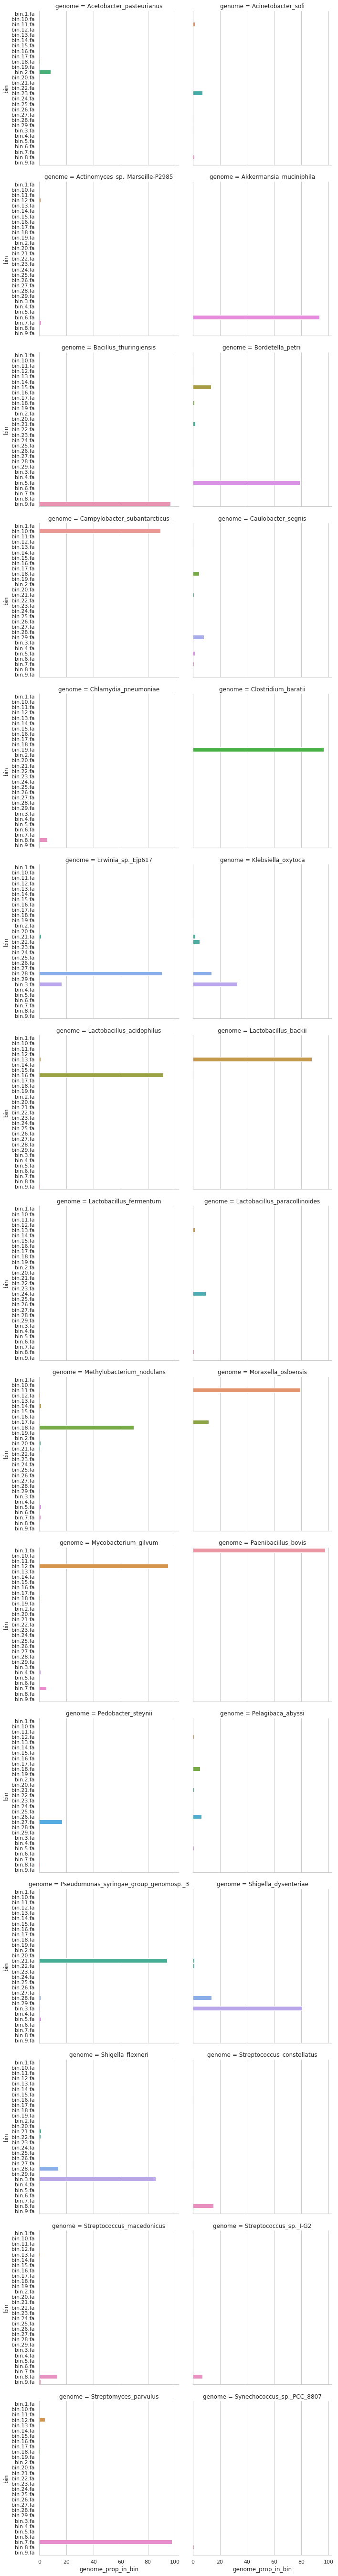

In [184]:
binned_cov = genome_cov[genome_cov['bin'] != 'bin.unbinned.fa']
sns.catplot(kind='bar', data = binned_cov, col='genome', col_wrap=2, x='genome_prop_in_bin', y='bin')

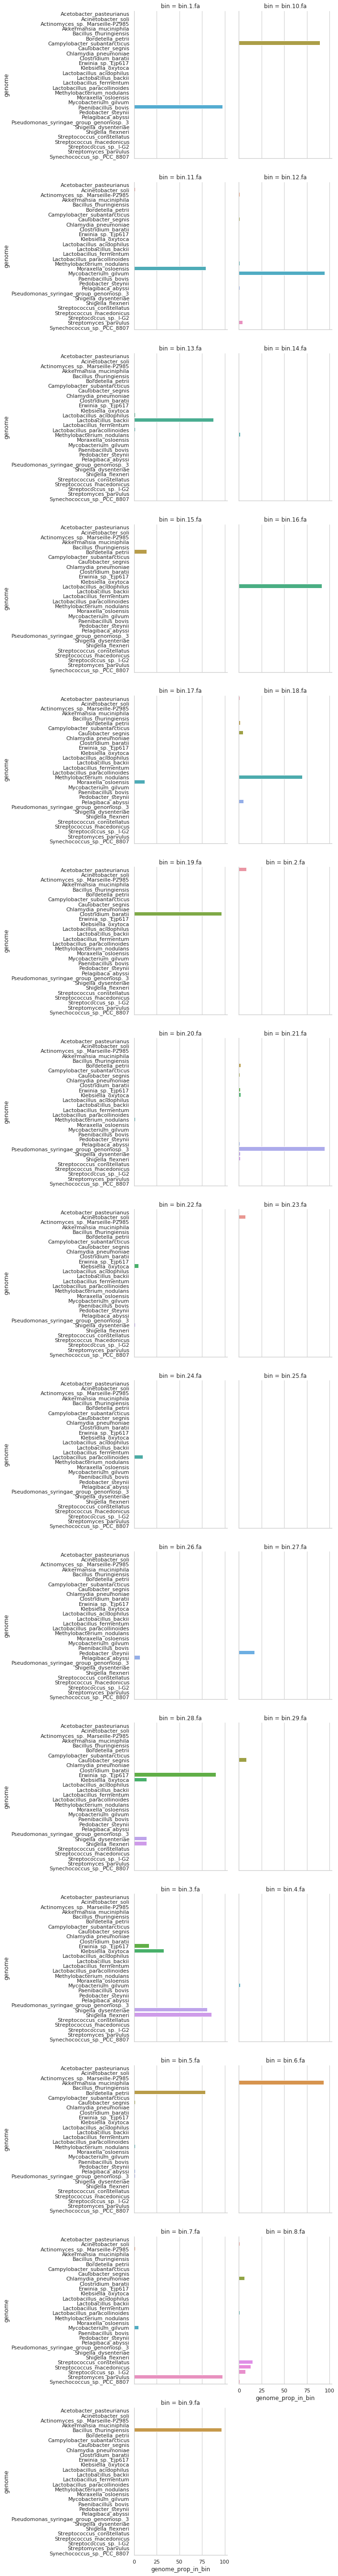

In [185]:
sns.catplot(kind = 'bar', data = binned_cov, col='bin', col_wrap=2, x='genome_prop_in_bin', y='genome')

very crude single genome IDs for each bin based on which genome 
that bin contains the most of 

In [186]:
sorted_cov = genome_cov.sort_values(['bin', 'genome_prop_in_bin']).groupby('bin').tail(1)
bin_ids = sorted_cov.drop('genome_prop_in_bin', axis=1).set_index('bin')

# Plasmids

How many plasmids were recovered and were they in the same bin as their respective chromosomes

In [187]:
plas_df = pd.read_csv('plasmid_coverage/plasmid_blast_all.out6', 
                 sep='\t', 
                 names = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovs bin".split())

plas_df['coverage'] = plas_df['length'] / plas_df['qlen'] * 100
plas_df = plas_df.sort_values('coverage', ascending=False)
plas_df['plas_genome'] = plas_df['qseqid'].str.split(':').str.get(0)
plas_df['plas_acc'] = plas_df['qseqid'].str.split(':').str.get(1)


plas_df = plas_df.set_index('bin')
plas_df['bin_id'] = bin_ids['genome']
plas_df = plas_df.reset_index()

In [233]:
plas_counts = !ls -1 ../data/sequences/*/*/plasmid/*.fasta
plas_counts = [x.split('/')[3] for x in plas_counts]
plas_counts = pd.Series(collections.Counter(plas_counts))

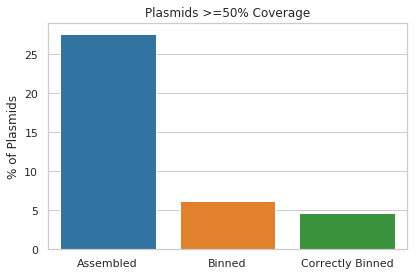

In [234]:
correct_plas_df = plas_df[['bin', 'bin_id', 'plas_genome', 'plas_acc', 'coverage']]
correct_plas_df = correct_plas_df[correct_plas_df['bin_id'] == correct_plas_df['plas_genome']]
# 50% coverage or more
correct_plas_df = correct_plas_df[correct_plas_df['coverage'] > 50]

# number of correctly binned plasmids i.e. with chromosomes bin
correctly_binned_plasmids = correct_plas_df.groupby('bin_id').size().sum()

# total assembled plasmids
total_recovered = plas_df[plas_df['coverage'] > 50]['plas_acc'].drop_duplicates().value_counts().sum()

# total binned plasmids
binned = plas_df[(plas_df['coverage'] > 50) & (plas_df['bin'] != 'bin.unbinned.fa')]['plas_acc'].drop_duplicates().value_counts().sum()

df = pd.Series({'Correctly Binned': correctly_binned_plasmids,
                'Binned': binned,
                'Assembled': total_recovered})
df = df.reset_index().rename(columns={'index': 'Category', 0: "Number of Plasmids"})
df['% of Plasmids'] = df['Number of Plasmids'] / plas_count.sum() * 100

sns.barplot(data = df, x = 'Category', y='% of Plasmids')
plt.title('Plasmids >=50% Coverage')
plt.xlabel('')
plt.tight_layout()
plt.savefig('mag_plasmids.pdf')

# Genomic Islands

In [241]:
gi_df = pd.read_csv('gi_coverage/gs_blast_all.out6',
                 sep='\t', 
                 names = "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovs bin".split())


gi_df['gi_genome'] = gi_df['qseqid'].str.split(':').str.get(0)
gi_df = gi_df.set_index('bin')
gi_df['bin_id'] = bin_ids['genome']
gi_df = gi_df.reset_index()
gi_df['coverage'] = gi_df['length'] / gi_df['qlen'] * 100




gi_counts = !grep -c "^>" ../data/sequences/*/gis/*.fasta
gi_counts = {x.split('/')[3]: int(x.split(':')[-1]) for x in gi_counts}
gi_counts = pd.Series(gi_counts)

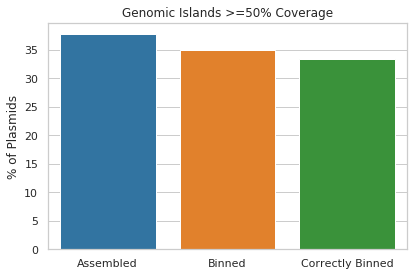

In [242]:

# drop coverage <50%
gi_df = gi_df[gi_df['coverage'] > 50]

# assembled gis
assembled_gis = gi_df['qseqid'].drop_duplicates().value_counts().sum()

# binned in any bin gis
binned_gis = gi_df[gi_df['bin'] != 'bin.unbinned.fa']['qseqid'].drop_duplicates().value_counts().sum()

# correctly binned into same as chromosome
correctly_binned = gi_df[gi_df['gi_genome'] == gi_df['bin_id']]['qseqid'].drop_duplicates().value_counts().sum()


df = pd.Series({'Correctly Binned': correctly_binned,
                'Binned': binned_gis,
                'Assembled': assembled_gis})
df = df.reset_index().rename(columns={'index': 'Category', 0: "Number of Genomic Islands"})
df['% of Plasmids'] = df['Number of Genomic Islands'] / gi_counts.sum() * 100

sns.barplot(data = df, x = 'Category', y='% of Plasmids')
plt.title('Genomic Islands >=50% Coverage')
plt.xlabel('')
plt.tight_layout()
plt.savefig('mag_gis.pdf')